<a href="https://colab.research.google.com/github/Vic-bit/aprendizaje_profundo/blob/master/SILVA_VICTOR_DL_Examen_ABRIL_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Junio 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el **Lunes 24 de junio**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen ABRIL 2024.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros
- numero de capas.
- numero de kernels.
- tamaño de kernels.


a) Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor.

b) Al mejor modelo, aplique capas de dropout para ver si puede mejorar sus métricas.



In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import random
import matplotlib.pyplot as plt

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


100%|██████████| 26421880/26421880 [00:02<00:00, 9280306.87it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272307.08it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5062063.92it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13805803.70it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# Se forma el dataloader para crear batches de datasets
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

### Exploración del dataset

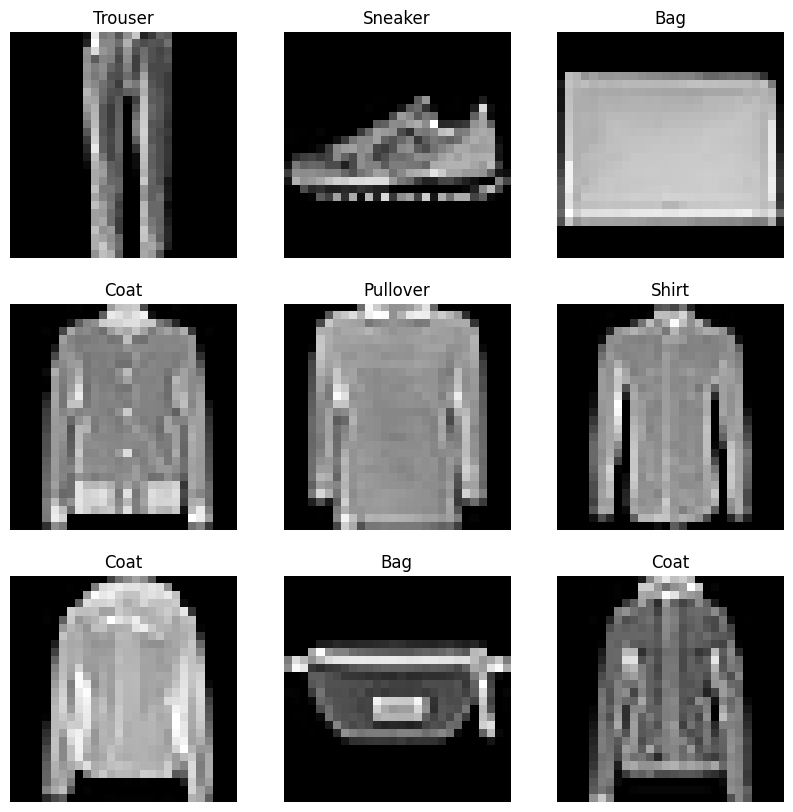

In [5]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [6]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [7]:
# Ver imagen and label del dataloader
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


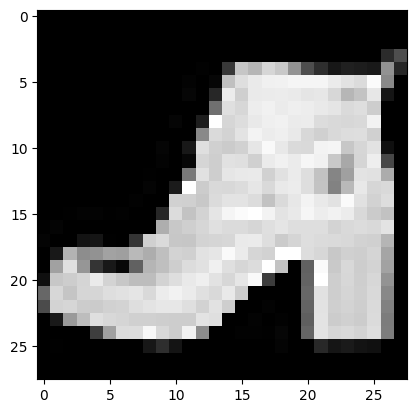

Label: 9


In [8]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[22]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(0.)
pixel maximo:  tensor(1.)
pixel minimo:  tensor(0.)


### Función para entrenar el modelo

In [10]:
# Se arman las funciones necesarias para realizar el entrenamiento
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

    train_loss = epoch_t_loss[-1]
    val_loss = epoch_v_loss[-1]
    train_acc = epoch_t_acc[-1]
    val_acc = epoch_v_acc[-1]

    print('train loss: ', train_loss)
    print('val loss: ', val_loss)
    print('train acc: ', train_acc)
    print('val acc: ', val_acc)

    return train_loss, val_loss, train_acc, val_acc
    # Se muestran los valores obtenidos de loss y acc para train y loss


### Construcción de las CNN



#### Modelo 1

##### Bloque de convolución

In [83]:
# Bloque de convolución para emplear en la red
def conv_block_1(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

##### CNN

In [84]:
class CNN_1(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_1(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_1(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_1(16, 32)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # Se imprime el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Se imprime el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [85]:
model1 = CNN_1()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  21386


In [86]:
summary(model1.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
              Tanh-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]          12,832
              Tanh-8             [-1, 32, 7, 7]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Linear-10                   [-1, 10]           5,130
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.08
Estimated Tot

In [87]:
# Verificamos la consistencia de las dimensiones
model1.cpu()
model1.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 14, 14])
Tamaño salida conv2:  torch.Size([1, 16, 7, 7])
Tamaño salida conv3:  torch.Size([1, 32, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


##### Se entrena el modelo 1

val_loss 0.78858 val_acc 0.71467: 100%|██████████| 157/157 [00:01<00:00, 87.63it/s]


Epoch 1/5 loss 1.10739 val_loss 0.78858 acc 0.61324 val_acc 0.71467


val_loss 0.61532 val_acc 0.77199: 100%|██████████| 157/157 [00:02<00:00, 67.66it/s]


Epoch 2/5 loss 0.66584 val_loss 0.61532 acc 0.75801 val_acc 0.77199


val_loss 0.54054 val_acc 0.79966: 100%|██████████| 157/157 [00:01<00:00, 83.59it/s]


Epoch 3/5 loss 0.55136 val_loss 0.54054 acc 0.79902 val_acc 0.79966


val_loss 0.49835 val_acc 0.81549: 100%|██████████| 157/157 [00:01<00:00, 85.53it/s]


Epoch 4/5 loss 0.49775 val_loss 0.49835 acc 0.81891 val_acc 0.81549


val_loss 0.46913 val_acc 0.82763: 100%|██████████| 157/157 [00:01<00:00, 84.26it/s]


Epoch 5/5 loss 0.45998 val_loss 0.46913 acc 0.83287 val_acc 0.82763


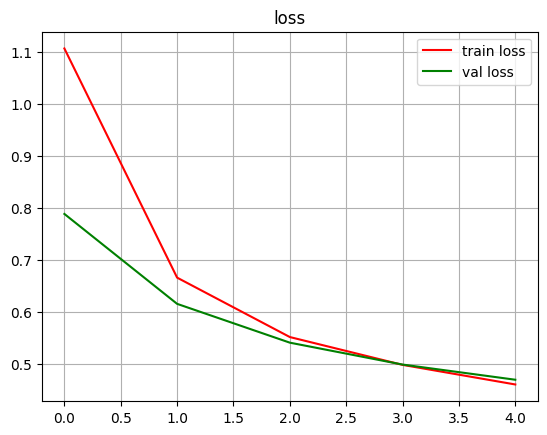

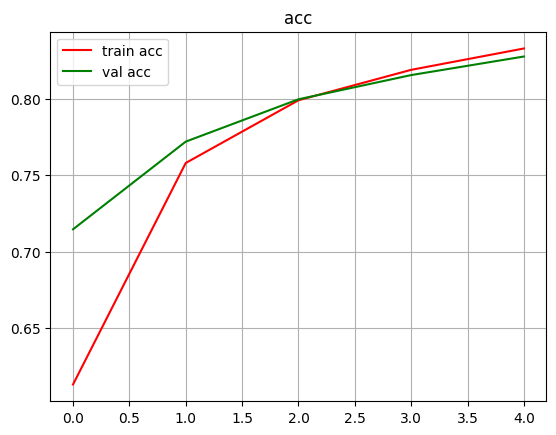

train loss:  0.45998069191220475
val loss:  0.46913195491596393
train acc:  0.8328724680170576
val acc:  0.8276273885350318


In [88]:
train_loss_1, val_loss_1, train_acc_1, val_acc_1 = fit(model1, dataloader, epochs=5)

#### Modelo 2:

- se incrementa el kernel de 5 a 9
- se incrementa el padding de 3 a 5
- se aumenta el stride de 1 a 2.

##### Bloque de convolución

In [89]:
# Bloque de convolución para emplear en la red
def conv_block_2(c_in, c_out, k=9, p=5, s=2, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

##### CNN

In [91]:
class CNN_2(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_2(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_2(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_2(16, 32)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(128, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # Se imprime el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Se imprime el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [92]:
model2 = CNN_2()

Red creada
arquitectura:
CNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(9, 9), stride=(2, 2), padding=(5, 5))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(5, 5))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(2, 2), padding=(5, 5))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  53834


In [93]:
summary(model2.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             656
              Tanh-2            [-1, 8, 15, 15]               0
         MaxPool2d-3              [-1, 8, 8, 8]               0
            Conv2d-4             [-1, 16, 5, 5]          10,384
              Tanh-5             [-1, 16, 5, 5]               0
         MaxPool2d-6             [-1, 16, 3, 3]               0
            Conv2d-7             [-1, 32, 3, 3]          41,504
              Tanh-8             [-1, 32, 3, 3]               0
         MaxPool2d-9             [-1, 32, 2, 2]               0
           Linear-10                   [-1, 10]           1,290
Total params: 53,834
Trainable params: 53,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Tot

In [94]:
# Verificamos la consistencia de las dimensiones
model2.cpu()
model2.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 8, 8])
Tamaño salida conv2:  torch.Size([1, 16, 3, 3])
Tamaño salida conv3:  torch.Size([1, 32, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 128])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


##### Se entrena el modelo 2

val_loss 0.76393 val_acc 0.72482: 100%|██████████| 157/157 [00:01<00:00, 85.34it/s]


Epoch 1/5 loss 1.19693 val_loss 0.76393 acc 0.59648 val_acc 0.72482


val_loss 0.60324 val_acc 0.77279: 100%|██████████| 157/157 [00:01<00:00, 87.13it/s]


Epoch 2/5 loss 0.64988 val_loss 0.60324 acc 0.75708 val_acc 0.77279


val_loss 0.53743 val_acc 0.79887: 100%|██████████| 157/157 [00:02<00:00, 66.83it/s]


Epoch 3/5 loss 0.55038 val_loss 0.53743 acc 0.79319 val_acc 0.79887


val_loss 0.49806 val_acc 0.81628: 100%|██████████| 157/157 [00:01<00:00, 87.19it/s]


Epoch 4/5 loss 0.49872 val_loss 0.49806 acc 0.81480 val_acc 0.81628


val_loss 0.46932 val_acc 0.82613: 100%|██████████| 157/157 [00:01<00:00, 85.25it/s]


Epoch 5/5 loss 0.46325 val_loss 0.46932 acc 0.82741 val_acc 0.82613


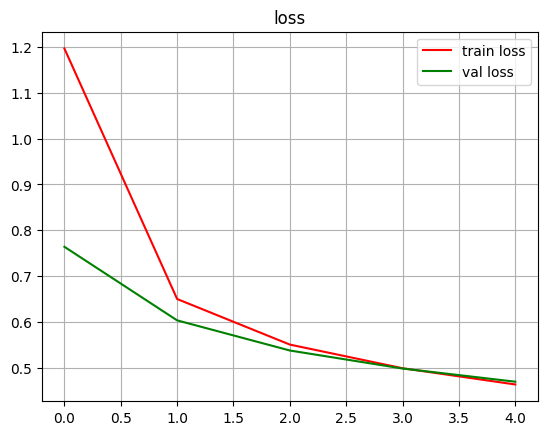

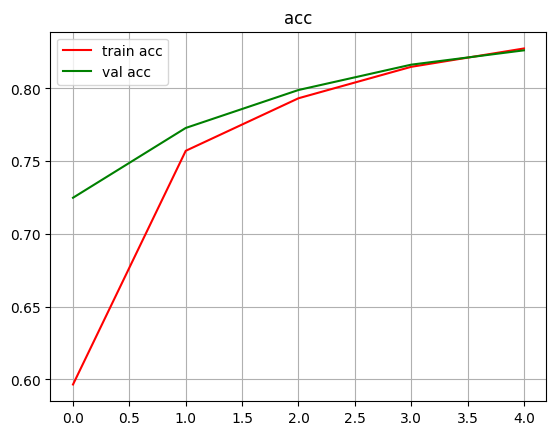

train loss:  0.4632471662753426
val loss:  0.4693218093768806
train acc:  0.8274087153518124
val acc:  0.8261345541401274


In [95]:
train_loss_2, val_loss_2, train_acc_2, val_acc_2 = fit(model2, dataloader, epochs=5)

#### Modelo 3:
- Se incrementa el kernel de pooling de 3 a 5.
- Se incrementa el padding  de pooling de 2 a 3.
- Se incrementa el stride de pooling  de 1 a 2.

##### Bloque de convolución

In [96]:
# Bloque de convolución para emplear en la red
def conv_block_3(c_in, c_out, k=5, p=2, s=1, pk=5, ps=3, pp=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

##### CNN

In [97]:
class CNN3(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_3(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_3(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_3(16, 32)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(32, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # Se imprime el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Se imprime el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [98]:
model3 = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(9, 9), stride=(2, 2), padding=(5, 5))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(5, 5))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(2, 2), padding=(5, 5))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  53834


In [99]:
summary(model3.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             656
              Tanh-2            [-1, 8, 15, 15]               0
         MaxPool2d-3              [-1, 8, 8, 8]               0
            Conv2d-4             [-1, 16, 5, 5]          10,384
              Tanh-5             [-1, 16, 5, 5]               0
         MaxPool2d-6             [-1, 16, 3, 3]               0
            Conv2d-7             [-1, 32, 3, 3]          41,504
              Tanh-8             [-1, 32, 3, 3]               0
         MaxPool2d-9             [-1, 32, 2, 2]               0
           Linear-10                   [-1, 10]           1,290
Total params: 53,834
Trainable params: 53,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Tot

In [100]:
# Verificamos la consistencia de las dimensiones
model3.cpu()
model3.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 8, 8])
Tamaño salida conv2:  torch.Size([1, 16, 3, 3])
Tamaño salida conv3:  torch.Size([1, 32, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 128])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


##### Se entrena el modelo 3

val_loss 0.73952 val_acc 0.72791: 100%|██████████| 157/157 [00:01<00:00, 84.22it/s]


Epoch 1/5 loss 0.92815 val_loss 0.73952 acc 0.66903 val_acc 0.72791


val_loss 0.60242 val_acc 0.77707: 100%|██████████| 157/157 [00:01<00:00, 82.41it/s]


Epoch 2/5 loss 0.64190 val_loss 0.60242 acc 0.76293 val_acc 0.77707


val_loss 0.53765 val_acc 0.80096: 100%|██████████| 157/157 [00:02<00:00, 73.03it/s]


Epoch 3/5 loss 0.54847 val_loss 0.53765 acc 0.79741 val_acc 0.80096


val_loss 0.49649 val_acc 0.81817: 100%|██████████| 157/157 [00:01<00:00, 84.03it/s]


Epoch 4/5 loss 0.49573 val_loss 0.49649 acc 0.81778 val_acc 0.81817


val_loss 0.46550 val_acc 0.82842: 100%|██████████| 157/157 [00:01<00:00, 86.07it/s]


Epoch 5/5 loss 0.45949 val_loss 0.46550 acc 0.83086 val_acc 0.82842


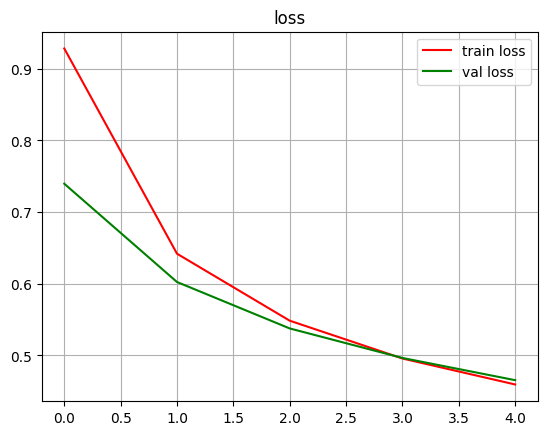

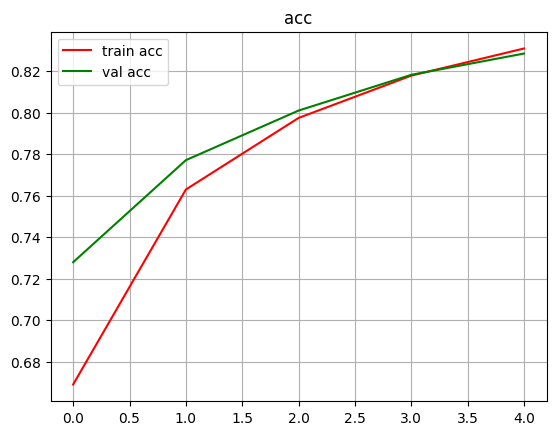

train loss:  0.4594931240274962
val loss:  0.4654952277233646
train acc:  0.8308568763326226
val acc:  0.8284235668789809


In [102]:
train_loss_3, val_loss_3, train_acc_3, val_acc_3 = fit(model3, dataloader, epochs=5)

#### Modelo 4

##### Bloque de convolución

In [103]:
# Bloque de convolución para emplear en la red
def conv_block_4(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

##### CNN

In [104]:
class CNN_4(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_4(n_channels, 16)
    self.conv1_out = None
    self.conv2 = conv_block_4(16,32)
    self.conv2_out = None
    self.conv3 = conv_block_4(32, 64)
    self.conv3_out = None
    self.conv4 = conv_block_4(64, 128)
    self.conv4_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # Se imprime el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Se imprime el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [105]:
model4 = CNN_4()

Red creada
arquitectura:
CNN_4(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entren

In [106]:
summary(model4.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              Tanh-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          51,264
              Tanh-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         204,928
             Tanh-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 10]           5,130
Total params: 274,570
Trainable params:

In [129]:
# Verificamos la consistencia de las dimensiones
model4.cpu()
model4.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 16, 14, 14])
Tamaño salida conv2:  torch.Size([1, 32, 7, 7])
Tamaño salida conv3:  torch.Size([1, 64, 4, 4])
Tamaño salida conv4:  torch.Size([1, 128, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


##### Se entrena el modelo 4

val_loss 0.55085 val_acc 0.79270: 100%|██████████| 157/157 [00:01<00:00, 80.05it/s]


Epoch 1/5 loss 0.78370 val_loss 0.55085 acc 0.72350 val_acc 0.79270


val_loss 0.48382 val_acc 0.81698: 100%|██████████| 157/157 [00:02<00:00, 67.92it/s]


Epoch 2/5 loss 0.48995 val_loss 0.48382 acc 0.81728 val_acc 0.81698


val_loss 0.41501 val_acc 0.84494: 100%|██████████| 157/157 [00:01<00:00, 80.95it/s]


Epoch 3/5 loss 0.41817 val_loss 0.41501 acc 0.84517 val_acc 0.84494


val_loss 0.38329 val_acc 0.85470: 100%|██████████| 157/157 [00:02<00:00, 71.46it/s]


Epoch 4/5 loss 0.37291 val_loss 0.38329 acc 0.86197 val_acc 0.85470


val_loss 0.37813 val_acc 0.85719: 100%|██████████| 157/157 [00:01<00:00, 81.42it/s]


Epoch 5/5 loss 0.34231 val_loss 0.37813 acc 0.87315 val_acc 0.85719


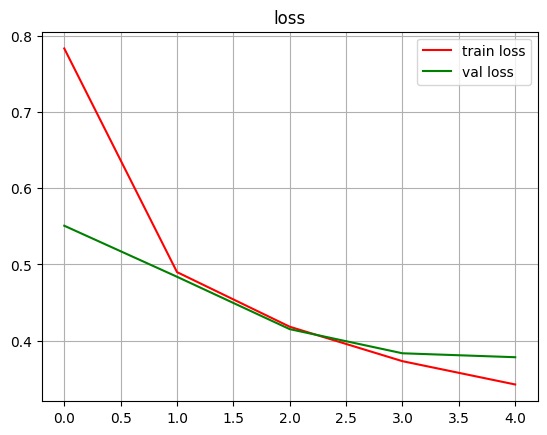

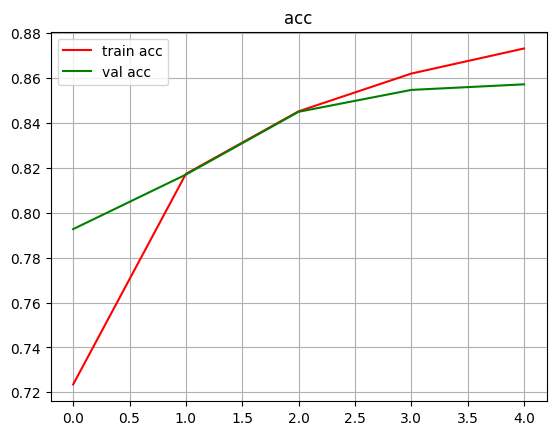

train loss:  0.3423133377454428
val loss:  0.37813390288383336
train acc:  0.873150986140725
val acc:  0.8571855095541401


In [108]:
train_loss_4, val_loss_4, train_acc_4, val_acc_4 = fit(model4, dataloader, epochs=5)

#### Modelo 5

##### Bloque de convolución

In [173]:
# Bloque de convolución para emplear en la red
def conv_block_5(c_in, c_out, k=3, p='same', s=1, pk=3, ps=1, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

##### CNN

In [178]:
class CNN_5(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_5(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_5(8,16)
    self.conv2_out = None
    self.conv3 = conv_block_5(16, 32)
    self.conv3_out = None
    self.conv4 = conv_block_5(32, 64)
    self.conv4_out = None
    self.conv5 = conv_block_5(64, 128)
    self.conv5_out = None
    self.fc = torch.nn.Linear(100352, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # Se imprime el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Se imprime el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out= self.conv5(self.conv4_out)
    y = self.conv5_out.view(self.conv5_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [179]:
model5 = CNN_5()

Red creada
arquitectura:
CNN_5(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dil

In [180]:
summary(model5.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,168
              Tanh-5           [-1, 16, 28, 28]               0
         MaxPool2d-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
              Tanh-8           [-1, 32, 28, 28]               0
         MaxPool2d-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          18,496
             Tanh-11           [-1, 64, 28, 28]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
             Tanh-14          [-1, 128,

In [181]:
# Verificamos la consistencia de las dimensiones
model5.cpu()
model5.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 28, 28])
Tamaño salida conv2:  torch.Size([1, 16, 28, 28])
Tamaño salida conv3:  torch.Size([1, 32, 28, 28])
Tamaño salida conv4:  torch.Size([1, 64, 28, 28])
Tamaño salida conv5:  torch.Size([1, 128, 28, 28])
Tamaño imagen vectorizada:  torch.Size([1, 100352])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


##### Se entrena el modelo 4

val_loss 0.40688 val_acc 0.85878: 100%|██████████| 157/157 [00:02<00:00, 68.20it/s]


Epoch 1/5 loss 0.52214 val_loss 0.40688 acc 0.81168 val_acc 0.85878


val_loss 0.35081 val_acc 0.87590: 100%|██████████| 157/157 [00:02<00:00, 65.98it/s]


Epoch 2/5 loss 0.36306 val_loss 0.35081 acc 0.87107 val_acc 0.87590


val_loss 0.32569 val_acc 0.88555: 100%|██████████| 157/157 [00:02<00:00, 68.05it/s]


Epoch 3/5 loss 0.32293 val_loss 0.32569 acc 0.88468 val_acc 0.88555


val_loss 0.32851 val_acc 0.88426: 100%|██████████| 157/157 [00:02<00:00, 67.47it/s]


Epoch 4/5 loss 0.29800 val_loss 0.32851 acc 0.89436 val_acc 0.88426


val_loss 0.30916 val_acc 0.89013: 100%|██████████| 157/157 [00:02<00:00, 68.19it/s]


Epoch 5/5 loss 0.28485 val_loss 0.30916 acc 0.89894 val_acc 0.89013


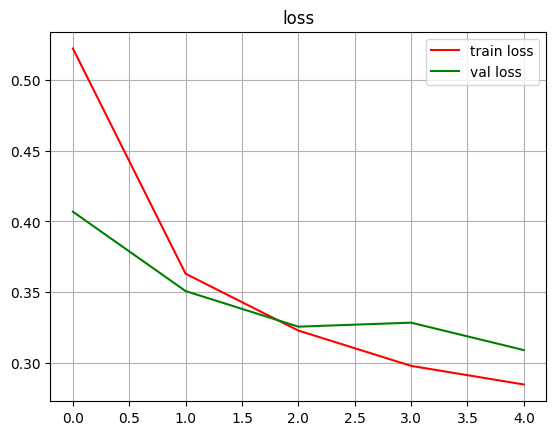

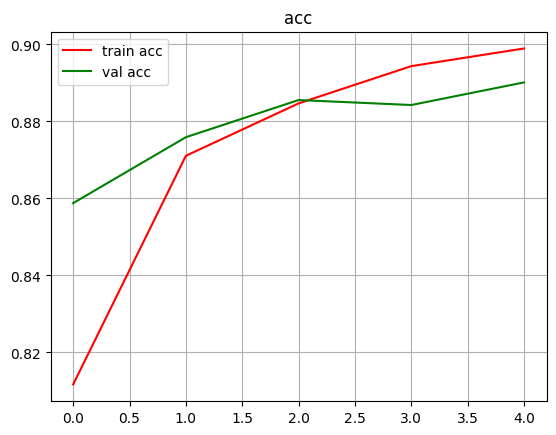

train loss:  0.28485459364903
val loss:  0.3091588533323282
train acc:  0.8989372334754797
val acc:  0.8901273885350318


In [182]:
train_loss_5, val_loss_5, train_acc_5, val_acc_5 = fit(model5, dataloader, epochs=5)

### Se realiza una comparación de desempeño entre los modelos

In [185]:
from tabulate import tabulate
resultados = {
    "Algorithm": ["Modelo 1", "Modelo 2", "Modelo 3", "Modelo 4", "Modelo 5"],
    "Train loss": [train_loss_1, train_loss_2, train_loss_3, train_loss_4, train_loss_5],
    "Valid loss": [val_loss_1, val_loss_2, val_loss_3, val_loss_4, val_loss_5],
    "Train accuracy": [train_acc_1, train_acc_2, train_acc_3, train_acc_4, train_acc_5],
    "Valid accuracy": [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5],
}
encabezados = ["Train loss", "Valid loss", "Train accuracy", "Valid accuracy"]
print(tabulate(resultados, headers=encabezados, floatfmt=".5f"))

            Train loss    Valid loss    Train accuracy    Valid accuracy
--------  ------------  ------------  ----------------  ----------------
Modelo 1       0.45998       0.46913           0.83287           0.82763
Modelo 2       0.46325       0.46932           0.82741           0.82613
Modelo 3       0.45949       0.46550           0.83086           0.82842
Modelo 4       0.34231       0.37813           0.87315           0.85719
Modelo 5       0.28485       0.30916           0.89894           0.89013


Se observa en la tabla comparativa que el modelo con mejor desempeño tanto en loss como en accuracy fue el modelo 5, lo cual era de esperarse al tener mayor cantidad de capas que los otros modelos.

A continuación se le agregarán capas de dropout al modelo 5 para mejorar su desempeño.

In [11]:
# Bloque de convolución para emplear en la red
def conv_block_5(c_in, c_out, k=3, p='same', s=1, pk=3, ps=1, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [12]:
class CNN_5_DO(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_5(n_channels, 8)
    self.conv1_out = None
    self.drop = torch.nn.Dropout(p=0.7, inplace = False)
    self.conv2 = conv_block_5(8,16)
    self.conv2_out = None
    self.drop = torch.nn.Dropout(p=0.7, inplace = False)
    self.conv3 = conv_block_5(16, 32)
    self.conv3_out = None
    self.drop = torch.nn.Dropout(p=0.7, inplace = False)
    self.conv4 = conv_block_5(32, 64)
    self.conv4_out = None
    self.drop = torch.nn.Dropout(p=0.7, inplace = False)
    self.conv5 = conv_block_5(64, 128)
    self.conv5_out = None
    self.fc = torch.nn.Linear(100352, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # Se imprime el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Se imprime el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.drop(self.conv3(self.conv2_out))
    self.conv4_out = self.drop(self.conv4(self.conv3_out))
    self.conv5_out= self.conv5(self.conv4_out)
    y = self.conv5_out.view(self.conv5_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [13]:
model5_do = CNN_5_DO()

Red creada
arquitectura:
CNN_5_DO(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.7, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPoo

In [16]:
device = "cpu"
model5_do.to(device)
summary(model5_do,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              Tanh-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 28, 28]               0
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           4,640
             Tanh-10           [-1, 32, 28, 28]               0
        MaxPool2d-11           [-1, 32, 28, 28]               0
          Dropout-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
             Tanh-14           [-1, 64,

In [17]:
# Verificamos la consistencia de las dimensiones
model5_do.cpu()
model5_do.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 28, 28])
Tamaño salida conv2:  torch.Size([1, 16, 28, 28])
Tamaño salida conv3:  torch.Size([1, 32, 28, 28])
Tamaño salida conv4:  torch.Size([1, 64, 28, 28])
Tamaño salida conv5:  torch.Size([1, 128, 28, 28])
Tamaño imagen vectorizada:  torch.Size([1, 100352])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [ ]:
train_loss_5_do, val_loss_5_do, train_acc_5_do, val_acc_5_do = fit(model5_do, dataloader, epochs=5)

loss 1.00982 acc 0.62538:  74%|███████▍  | 695/938 [16:11<05:23,  1.33s/it]

### Verifica del funcionamiento del modelo

torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


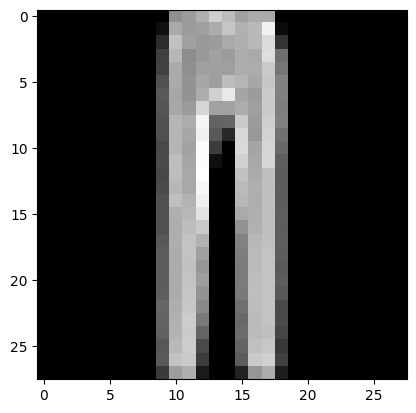

Tamaño imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-0.0897,  9.4886, -0.4353,  2.0062,  1.4065, -1.7110, -1.1367, -4.8422,
         -2.0716, -3.7318]], device='cuda:0')

softmax de predicción:
tensor([[6.9138e-05, 9.9896e-01, 4.8936e-05, 5.6231e-04, 3.0869e-04, 1.3665e-05,
         2.4267e-05, 5.9668e-07, 9.5277e-06, 1.8112e-06]], device='cuda:0')

La indumentaria es un:  Trouser


In [21]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 24

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))

# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'La indumentaria es un: ', labels_map[torch.argmax(y_hat, axis=1).item()])


## Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) e identificar los números mayores o menores a 4,5.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. (al reducir el train set, mantenga equilibrada la distribución de las clases!!)

Pruebe 2 estrategias de transfer learning distintas (acorde a los visto en la teoría) y comente para cada una, cual debería funcionar mejor justificando su respuesta.


Compare los resultados finales y comente.